#Object detetction: YOLO algorithm

##Done by: Amrou CHOUCHENE & Wassim BOUATAY

#### Reference: https://github.com/Garima13a/YOLO-Object-Detection


YOLO is a state-of-the-art, real-time object detection algorithm. In this notebook, we will apply the YOLO algorithm to detect objects in images. We will use COCO val2014 data set.


# Importing Resources

We will start by loading the required packages into Python. We will be using  a`utils` module that contains some helper functions, and a modified version of *Darknet*. YOLO uses *Darknet*, an open source, deep neural network framework written by the creators of YOLO. The version of *Darknet* used in this notebook has been simplified because we won't be doing any training. Instead, we will be using a set of pre-trained weights that were trained on the Common Objects in Context (COCO) database. We will clone Darknet from my personal github repository and connect weights from my personal drive folder.

In [1]:
#!pip install tensorflow==1.13.1
#!pip install keras==2.3.0
!pip install mapcalc

In [2]:
!git clone https://github.com/Amrou7/yolo.git

Cloning into 'yolo'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 67 (delta 26), reused 25 (delta 0), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [3]:
from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/My Drive/'

Mounted at /content/drive


# Importing libraries

In [4]:
import cv2
import matplotlib.pyplot as plt
import torch
from yolo.utils import *
from yolo.darknet import Darknet
import torchvision
import torchvision.datasets as dset
from mapcalc import calculate_map
import pandas as pd
import time
from skimage.io import imread

# Setting Up The Pretrained Neural Network

We will be using the latest version of YOLO, known as YOLOv3. We have already downloaded the `yolov3.cfg` file that contains the network architecture used by YOLOv3 and placed it in the `/cfg/` folder. Similarly, we have placed the `yolov3.weights` file that contains the pre-trained weights in my drive folder. Finally, the `/data/` directory, contains the `coco.names` file that has the list of the 80 object classes that the weights were trained to detect.


In [5]:
# Set the location and name of the cfg file
cfg_file = 'yolo/cfg/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = '/content/drive/My Drive/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = 'yolo/data/coco.names'
# Load the network architecture
m = Darknet(cfg_file)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#m.eval().to(device)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)
category_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']





# Taking a Look at The Neural Network

Now that the neural network has been setup, we can see what it looks like. We can print the network using the `.print_network()` function.

In [6]:
# Print the neural network used in YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

As we can see, the neural network used by YOLOv3 consists mainly of convolutional layers, with some shortcut connections and upsample layers.

# Loading data

We will use torch transforms in order to load images and the annotation file

In [7]:
coco = dset.CocoDetection(root = '/content/drive/My Drive/val2014',
                        annFile = '/content/drive/My Drive/instances_val2014.json',
                        transform=torchvision.transforms.ToTensor())

loading annotations into memory...
Done (t=7.72s)
creating index...
index created!




# Loading and Resizing an example of our images



As we can see in the previous cell, the input size of the first layer of the network is 416 x 416 x 3. Since images have different sizes, we have to resize our images to be compatible with the input size of the first layer in the network. In the code below, we resize our images using OpenCV's `cv2.resize()` function. We then plot the original and resized images. 

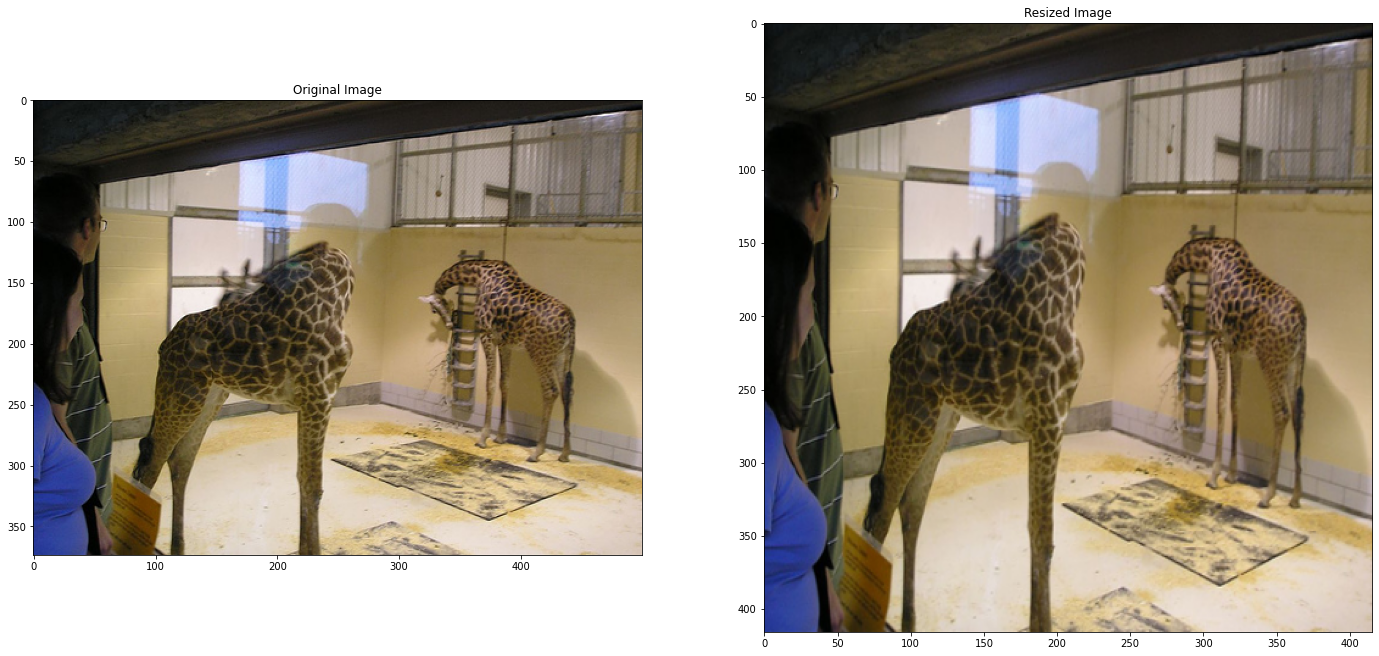

In [8]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24, 14]

# Load the image
try:
  img,target = coco[4]
  img = torchvision.transforms.ToPILImage()(img)
  img = np.array(img)
except:
  img=imread('yolo/images/cat.jpg')
  img = np.array(img)


# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(img, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

# Setting the Non-Maximal Suppression Threshold

YOLO uses **Non-Maximal Suppression (NMS)** to only keep the best bounding box. The first step in NMS is to remove all the predicted bounding boxes that have a detection probability that is less than a given NMS threshold.  In the code below, we set this NMS threshold to `0.6`. 

In [9]:
# Set the NMS threshold
nms_thresh = 0.6  

# Setting the Intersection Over Union Threshold

After removing all the predicted bounding boxes that have a low detection probability, the second step in NMS, is to select the bounding boxes with the highest detection probability and eliminate all the bounding boxes whose **Intersection Over Union (IOU)** value is higher than a given IOU threshold. In the code below, we set this IOU threshold to `0.4`. 

In the `utils` module you will find the `nms` function, that performs the second step of Non-Maximal Suppression, and the `boxes_iou` function that calculates the Intersection over Union of two given bounding boxes.

In [10]:
# Set the IOU threshold
iou_thresh = 0.4

# Object Detection

Once the image has been loaded and resized, and you have chosen your parameters for `nms_thresh` and `iou_thresh`, we can use the YOLO algorithm to detect objects in the image. We detect the objects using the `detect_objects(m, resized_image, iou_thresh, nms_thresh)`function from the `utils` module. This function takes in the model `m` returned by *Darknet*, the resized image, and the NMS and IOU thresholds, and returns the bounding boxes of the objects found.

Each bounding box contains 7 parameters: the coordinates *(x, y)* of the center of the bounding box, the width *w* and height *h* of the bounding box, the confidence detection level, the object class probability, and the object class id. 

Once we have the bounding boxes of the objects found by YOLO, we can print the class of the objects found and their corresponding object class probability. To do this we use the `print_objects()` function in the `utils` module.

Finally, we use the `plot_boxes()` function to plot the bounding boxes and corresponding object class labels found by YOLO in our image. If you set the `predicted` flag to `True` you will display the prediceted bounding boxes. And if you set the `ground_truth` flag to `True` you will display the ground truth bounding boxes in `green`.  You can set both flags to `True` and you will see all the bounding boxes.



**Ground truth boxes**

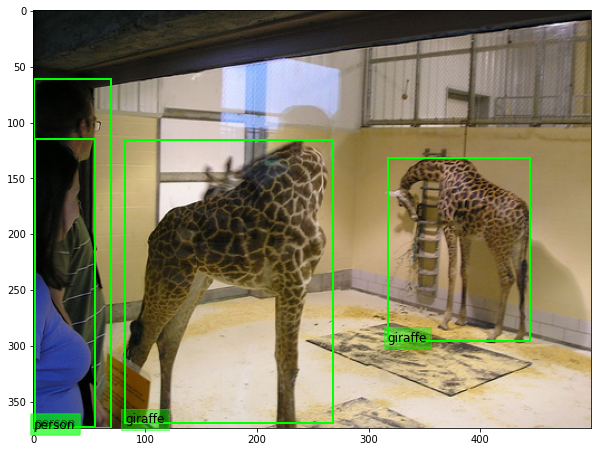

In [14]:

# Set the default figure size
plt.rcParams['figure.figsize'] = [10, 12]

# Load the image


img,target = coco[4]
img = torchvision.transforms.ToPILImage()(img)
img = np.array(img)



# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(img, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes ,time_ = detect_objects(m, resized_image, iou_thresh, nms_thresh)


#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(img, boxes, target ,class_names, category_names , predicted=False, ground_truth=True)

**Predicted boxes**

[[tensor(0.7613), tensor(0.5643), tensor(0.2855), tensor(0.4406), tensor(0.9995), tensor(1.0000), tensor(23)], [tensor(0.0662), tensor(0.5632), tensor(0.1331), tensor(0.7972), tensor(0.9806), tensor(1.), tensor(0)], [tensor(0.3511), tensor(0.6406), tensor(0.3800), tensor(0.7160), tensor(0.9365), tensor(1.0000), tensor(23)]]
Objects Found and Confidence Level:

1. giraffe: 0.999999
2. person: 1.000000
3. giraffe: 0.999960


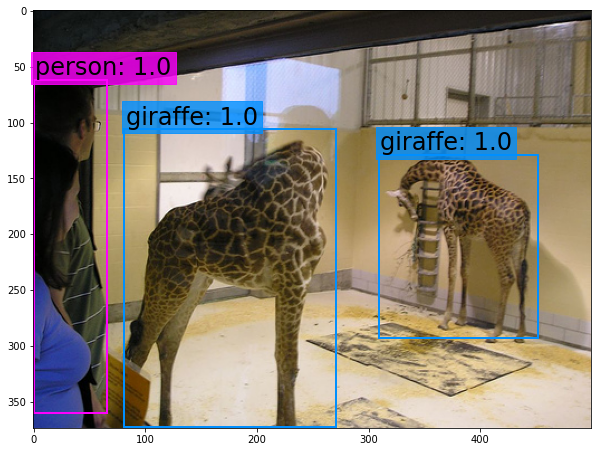

In [13]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [10, 12]

# Load the image


img,target = coco[4]
img = torchvision.transforms.ToPILImage()(img)
img = np.array(img)



# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(img, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes, time_= detect_objects(m, resized_image, iou_thresh, nms_thresh)
print(boxes)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(img, boxes, target ,class_names, category_names , predicted=True, ground_truth=False)

**All boxes**

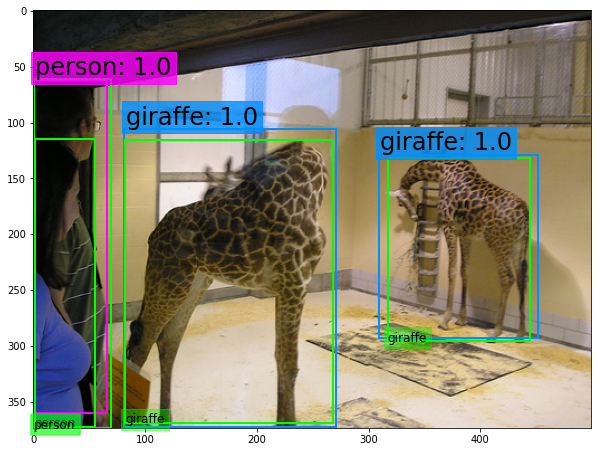

In [15]:
plt.rcParams['figure.figsize'] = [10,12]
plot_boxes(img, boxes, target ,class_names, category_names , predicted=True, ground_truth=True)

#Evaluating the performance of YOLO

We will perform our evaluation of YOLO based on 5 criterion:

1/ Time complexity

2/ IoU between predicted and ground truth boxes

3/ Precision

4/ Recall

5/ mAP (area under curve)

**Defining some useful functions**

In [16]:
def box_to_corners ( box , image_width , image_height ):
  '''transforms yolo predicted bounding boxes to other formats of bounding boxes
  input:
        -box: yolo bounding box [ x,y,w,h] where x,y are center coordinates, w and h are width and height proportions 
        of the bounding box with respect to the image
  output: 3 formats of bounding boxes
        - [xmin,ymin,xmax,ymax] : coordinates of lower left and upper right corners of the bounding box
        - [x_center, y_center, w,h]: coordinates of the center, width and height of the bounding box.  
        - [x_min,y_min,w,h]: coordinates of lower left corner, width and height of the bounding box. (format of the ground truth bounding boxes)'''
  box = list(map(float, box)) 
  xmin = box[0] - 0.5 * box[2]
  ymin = box[1] - 0.5 * box[3]
  xmax = box[0] + 0.5 * box[2]
  ymax = box[1] + 0.5 * box[3]
  if xmin <0:
    xmin = 0
  if xmax >1:
    xmax=1
  if ymin <0:
    ymin = 0
  if ymax >1:
    ymax=1

  res_corners = [] 
  res_corners.append(xmin*image_height)
  res_corners.append(ymin*image_width)
  res_corners.append(xmax*image_height)
  res_corners.append(ymax*image_width)

  res_center = [] 
  res_center.append( (xmin+xmax)*0.5*image_height )
  res_center.append( (ymin + ymax)*0.5*image_width )
  res_center.append( (xmax - xmin) * image_height )
  res_center.append( (ymax-ymin)*image_width)

  res_data = []
  res_data.append( res_corners[0] )
  res_data.append( res_corners[1] )
  res_data.append( (xmax - xmin) * image_height )
  res_data.append( (ymax-ymin)*image_width)

  return res_corners , res_center , res_data
  
def gt_boxes_format(box):
  """
  transform the format of ground truth bounding box to the format [xmin,ymin,xmax,ymax]
  """
  return [box[0], box[1], box[0]+box[2], box[1]+box[3]]



def bbox_iou(boxA, boxB):
  """
  Calculating the IoU between 2 boxes in the format 
  [ top_left xmin, top_left ymin, lower_right xmax, lower_right ymax]
  """
  # Determine the coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])

  interW = xB - xA + 1
  interH = yB - yA + 1

  # Reject non-overlapping boxes
  if interW <=0 or interH <=0 :
    return -1.0

  interArea = interW * interH
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  iou = interArea / float(boxAArea + boxBArea - interArea)
  return iou

def rename(name):
  if name=='tvmonitor':
    return 'tv'
  if name=='diningtable':
    return 'dining table'
  if name=='pottedplant':
    return 'potted plant'
  if name=='sofa':
    return 'couch'
  if name=='aeroplane':
    return 'airplane'
  if name=='motorbike':
    return 'motorcycle'
  return name


**Evaluation script**

In [17]:
## stat_per_class: [true predicted bounding box , predicted bounding box , gt bounding box] ( used for precision recall)
stat_per_class = {'person':[0,0,0], 'car':[0,0,0], 'chair':[0,0,0], 'book':[0,0,0], 'bottle':[0,0,0], \
                    'cup':[0,0,0], 'dining table':[0,0,0], 'bowl':[0,0,0], 'traffic light':[0,0,0],\
                    'handbag':[0,0,0], 'other':[0,0,0]}

## iou_per_class: [sum of ious , number of true matches] 
iou_per_class = {'person':[0,0], 'car':[0,0], 'chair':[0,0], 'book':[0,0], 'bottle':[0,0], \
                    'cup':[0,0], 'dining table':[0,0], 'bowl':[0,0], 'traffic light':[0,0],\
                    'handbag':[0,0], 'other':[0,0]}

##mAP calculation
res_target = {'person':{ 'boxes':[] , 'labels':[] }, 'car':{ 'boxes':[] , 'labels':[] }, 'chair':{ 'boxes':[] , 'labels':[] }, 'book':{ 'boxes':[] , 'labels':[] }, 'bottle':{ 'boxes':[] , 'labels':[] }, \
                    'cup':{ 'boxes':[] , 'labels':[] }, 'dining table':{ 'boxes':[] , 'labels':[] }, 'bowl':{ 'boxes':[] , 'labels':[] }, 'traffic light':{ 'boxes':[] , 'labels':[] },\
                    'handbag':{ 'boxes':[] , 'labels':[] }, 'other':{ 'boxes':[] , 'labels':[] }}
res_boxes =   {'person':{ 'boxes':[] , 'labels':[] , 'scores':[] }, 'car':{ 'boxes':[] , 'labels':[] , 'scores':[] }, 'chair':{ 'boxes':[] , 'labels':[] , 'scores':[] }, 'book':{ 'boxes':[] , 'labels':[] , 'scores':[] }, 'bottle':{ 'boxes':[] , 'labels':[] , 'scores':[] }, \
                    'cup':{ 'boxes':[] , 'labels':[] , 'scores':[] }, 'dining table':{ 'boxes':[] , 'labels':[] , 'scores':[] }, 'bowl':{ 'boxes':[] , 'labels':[] , 'scores':[] }, 'traffic light':{ 'boxes':[] , 'labels':[] , 'scores':[] },\
                    'handbag':{ 'boxes':[] , 'labels':[] , 'scores':[] }, 'other':{ 'boxes':[] , 'labels':[] , 'scores':[] }}

top_ten = ['person', 'car', 'chair', 'book', 'bottle', 'cup', 'dining table', 'bowl', 'traffic light', 'handbag']
total_time=0
total_samples=0

for k in range(len(coco)):
    try:
      img,target = coco[k]
      img = torchvision.transforms.ToPILImage()(img)
      img = np.array(img)
      total_samples +=1
    except:
      continue
    indexes_target=[]

    # We resize the image to the input width and height of the first layer of the network.    
    resized_image = cv2.resize(img, (m.width, m.height))

    # Set the IOU threshold. Default value is 0.4
    iou_thresh = 0.4

    # Set the NMS threshold. Default value is 0.6
    nms_thresh = 0.6

    # Detect objects in the image
    boxes, time_ = detect_objects(m, resized_image, iou_thresh, nms_thresh)
    total_time+= time_


    for i in boxes:
      if float (i[4] ) > 0:
        name = rename( class_names[int(i[-1])] )
        try: 
          index = top_ten.index(name)
          stat_per_class[ name ][1] += 1
        except:
          stat_per_class[ 'other' ][1] += 1

    for obj in target:
        name = category_names[ obj['category_id'] - 1 ]
        try: 
          index = top_ten.index(name)
          stat_per_class[ name ][2] += 1
        except:
          stat_per_class[ 'other' ][2] += 1

    # Create a PyTorch Tensor to keep track of the detection confidence
    # of each predicted bounding box

    det_confs = torch.zeros(len(boxes))
        
    # Get the detection confidence of each predicted bounding box
    for i in range(len(boxes)):
        det_confs[i] = boxes[i][4]

    # Sort the indices of the bounding boxes by detection confidence value in descending order.
    # We ignore the first returned element since we are only interested in the sorted indices
    _,sortIds = torch.sort(det_confs, descending = True)
    visited = dict() 
    for i in range(len(boxes)):
      box_i = boxes[sortIds[i]]
      iouu = -1
      index = -1

      for j in range(len(target)):
        obj = target[j]
        if bbox_iou( box_to_corners( box_i , img.shape[0] , img.shape[1] )[0], gt_boxes_format (obj['bbox']) ) > iouu:
          iouu = bbox_iou( box_to_corners( box_i, img.shape[0] , img.shape[1] )[0], gt_boxes_format (obj['bbox']) )
          index = j
      if index!=-1:
        #indexes_target.append(index)
        if rename( class_names[ int( box_i[-1]) ] ) == category_names[ target[index]['category_id'] - 1]:
          name = rename( class_names[ int( box_i[-1]) ] )
          try:
            ind = top_ten.index(name)
            stat_per_class[ name ][0] +=1
            iou_per_class [ name ][0]+=iouu
            iou_per_class [ name ][1]+=1
            res_boxes[name]['boxes'].append( box_to_corners ( box_i , img.shape[0] , img.shape[1] )[0] )
            res_boxes[name]['labels'].append(  int( box_i[-1] )  )
            res_boxes[name]['scores'].append( float(box_i[4]) )
            res_target[name]['boxes'].append( gt_boxes_format( target[index]['bbox'] ) )
            res_target[name]['labels'].append( int( box_i[-1] )  )
          except:
            stat_per_class[ 'other'][0] +=1
            iou_per_class [ 'other'][0] +=iouu
            iou_per_class [ 'other'][1] +=1
            res_boxes['other']['boxes'].append( box_to_corners ( box_i , img.shape[0] , img.shape[1] )[0] )
            res_boxes['other']['labels'].append( len(class_names)  )
            res_boxes['other']['scores'].append( float(box_i[4]) )
            res_target['other']['boxes'].append( gt_boxes_format( target[index]['bbox'] ) )
            res_target['other']['labels'].append( len(class_names) )
    




In [ ]:
print("Time for executing YOLO for {} images is : {} s".format( total_samples ,  total_time))
print("which is equivalent to {0:.0f}min {1:02.0f}s ".format( *divmod( total_time , 60)) )
print("On average ,  {0:.0f}s {1:03.0f}ms for one image".format( *divmod( total_time*1000/total_samples  , 1000)) )

Time for executing YOLO for 8723 images is : 10142.076779603958 s
which is equivalent to 169min 02s 
On average ,  1s 163ms for one image


**Results**

In [ ]:
columns = {'Metrics':['mAP@.75', 'IoU', 'Recall', 'Precision'], 'All Classes':[0]*4,\
           'person':[0]*4, 'car':[0]*4, 'chair':[0]*4, 'book':[0]*4, \
           'bottle':[0]*4, 'cup':[0]*4, 'dining table':[0]*4, 'bowl':[0]*4, \
           'traffic light':[0]*4, 'handbag':[0]*4, 'other':[0]*4}
df = pd.DataFrame(columns, dtype='float')
df.set_index('Metrics')


,All Classes,person,car,chair,book,bottle,cup,dining table,bowl,traffic light,handbag,other
Metrics,,,,,,,,,,,,
mAP@.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IoU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
all_labels= top_ten + ['other']
res_all_target = { 'boxes':[] , 'labels':[] }
res_all_boxes = { 'boxes':[] , 'labels':[] , 'scores':[] }
nb_true = 0
nb_pred_true = 0
nb_gt = 0
nb_true_matches = 0
sum_iouu = 0
for label in all_labels:
  nb_true += stat_per_class[label][0]
  nb_pred_true += stat_per_class[label][1]
  nb_gt += stat_per_class[label][2]
  sum_iouu += iou_per_class[label][0]
  nb_true_matches += iou_per_class[label][1]
  for i in range( len( res_target[label]['boxes'] ) ) :
    res_all_target['boxes'].append( res_target[label]['boxes'][i])
    res_all_target['labels'].append( res_target[label]['labels'][i])
    res_all_boxes['labels'].append( res_boxes[label]['labels'][i])
    res_all_boxes['boxes'].append( res_boxes[label]['boxes'][i])
    res_all_boxes['scores'].append( res_boxes[label]['scores'][i])


for label in all_labels:
  if len( res_boxes[label]['boxes']) !=0 :
    df[label][0]= calculate_map(res_target[label], res_boxes[label], 0.75)
  else:
    df[label][0]=0
  if iou_per_class[label][1] !=0 :
    df[label][1]= iou_per_class[label][0] / iou_per_class[label][1]
  else:
    df[label][1]=0
  if stat_per_class[label][2] !=0 :
    df[label][2]= stat_per_class[label][0] / stat_per_class[label][2]
  else:
    df[label][2]=0
  if stat_per_class[label][1] !=0 :
    df[label][3]= stat_per_class[label][0] / stat_per_class[label][1]
  else:
    df[label][3]=0

df['All Classes'][0] = calculate_map(res_all_target, res_all_boxes, 0.75)
df['All Classes'][1] = sum_iouu / nb_true_matches
df['All Classes'][2] = nb_true/nb_gt 
df['All Classes'][3] = nb_true/nb_pred_true
df


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to b

,Metrics,All Classes,person,car,chair,book,bottle,cup,dining table,bowl,traffic light,handbag,other
0,mAP@.75,0.419054,0.411889,0.472554,0.487444,0.086097,0.390911,0.605092,0.411933,0.615297,0.290525,0.348209,0.489645
1,IoU,0.760365,0.736032,0.765973,0.771116,0.566109,0.731324,0.811253,0.792754,0.801106,0.720971,0.736347,0.784501
2,Recall,0.539562,0.699400,0.558495,0.360269,0.230856,0.426979,0.484809,0.330695,0.472404,0.410944,0.134796,0.506720
3,Precision,0.940493,0.966390,0.908243,0.917143,0.942529,0.924005,0.866051,0.852608,0.854484,0.972081,0.786585,0.934905
